<a href="https://colab.research.google.com/github/Stefanie04/MindMate/blob/main/Notebook_Stefanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start ▶

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
#from google.colab import drive
#drive.mount('/content/drive')

import json

import io
import re
import random
import string
import tqdm

import tensorflow as tf
from tensorflow.keras import layers

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sdonthi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
with open('Dataset/intents-rev2.json', 'r') as f:
    json_string = f.read()

# Preperation of the dataset 🚧

In [4]:
json_dict = json.loads(json_string)
intents = json_dict['intents']

In [5]:
df =pd.DataFrame(intents)

In [6]:
tags = []
patterns = []
responses = {}
for intents in json_dict['intents']:
    responses[intents['tag']]=intents['responses']
    for lines in intents['patterns']:
      patterns.append(lines)
      tags.append(intents['tag'])

In [7]:
json_df = pd.DataFrame({'tags':tags, 'patterns':patterns})

In [8]:
pd.set_option('display.max_rows', json_df.shape[0]+1)

In [9]:
json_df['tags']

0                                               greeting
1                                               greeting
2                                               greeting
3                                               greeting
4                                               greeting
5                                               greeting
6                                               greeting
7                                               greeting
8                                               greeting
9                                               greeting
10                                              greeting
11                                              greeting
12                                               morning
13                                             afternoon
14                                               evening
15                                                 night
16                                               goodbye
17                             

# Pre-Processing 🏗

## Lowercases / removing punctuation

In [10]:
pre_df = json_df.apply(lambda x: x.astype(str).str.lower())

import string
pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))

C:\Users\sdonthi\AppData\Local\Temp/ipykernel_17504/1545242841.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))


## Tokenization

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Create a Tokenizer object
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(pre_df['patterns'])
tokenized_text = tokenizer.texts_to_sequences(pre_df['patterns'])

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenized_text)

from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
encoder = LabelEncoder()
y_train = encoder.fit_transform(pre_df['tags'])

In [25]:
pre_df.to_pickle('pre_df.pkl')

In [12]:
# Creating the word list
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 443 unique tokens.


In [13]:
print(x_train.shape)
print(y_train.shape)

(330, 21)
(330,)


In [14]:
output_length = encoder.classes_.shape[0]
print('Output length: ', output_length)

Output length:  166


# Model 🕸

In [15]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Flatten, Dense, Dropout

In [16]:
input_size = x_train.shape[1]
output_size = encoder.classes_.shape[0]

In [32]:
output_size

166

In [17]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 16, input_shape=(input_size,)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(output_length, activation='sigmoid'))

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6742 - accuracy: 0.7788
Epoch 2/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6772 - accuracy: 0.7758
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6787 - accuracy: 0.7788
Epoch 4/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6362 - accuracy: 0.7879
Epoch 5/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6531 - accuracy: 0.7970
Epoch 6/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6361 - accuracy: 0.7970
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6371 - accuracy: 0.7758
Epoch 8/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6187 - accuracy: 0.7879
Epoch 9/200
11/11 [==============================] - 0s 13ms/step - loss: 0.6135 - accuracy: 0.7970
Epoch 10/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6105 - accuracy: 0.8061

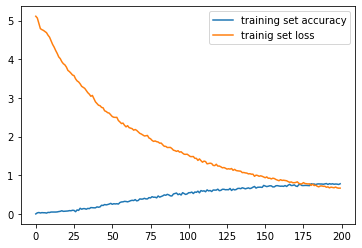

In [20]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='trainig set loss')
plt.legend()

In [21]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


#Chatbot 🤖

In [162]:
""" while True:
  conversation = []
  user_input = input('User: ')
  if user_input == 'bye':
    print('Goodbye and take care.')
    break

  # converting lowercase / removing punctuation 
  user_input = user_input.lower()
  user_input = re.sub(r'[^\w\s]', '', user_input)
  conversation.append(user_input)

  # tokenizer / padding
  user_input = tokenizer.texts_to_sequences(conversation)
  user_input = np.array(user_input).reshape(-1)
  user_input = pad_sequences([user_input], input_size)

  # output
  output = model.predict(user_input)
  output = output.argmax()

  # prediction
  response = encoder.inverse_transform([output])[0]
  print('response=' + response)
  if response in responses:
    print('Pocket Therapist: ', random.choice(responses[response]))
  else:
    print('Sorry, I do not understand. Can you please rephrase?')
  if response == 'goodbye':
    break """

User: hi
1/1 [==============================] - 0s 27ms/step
response=greeting
Pocket Therapist:  Hello there. Tell me how are you feeling today?
User: bye
Goodbye and take care.


In [22]:
model.save(filepath='./saved_model/', include_optimizer=True, overwrite=True)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [29]:
model.save('mindmate_model.h5')